<a href="https://colab.research.google.com/github/AhmedZayed777/Water-Segmentation--MultiSpectral/blob/main/Water_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import cv2
import os
import tifffile as tiff
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Input # type: ignore
from tensorflow.keras.models import Sequential # type: ignore


# **Visualizations**

Image shape: (128, 128, 12)


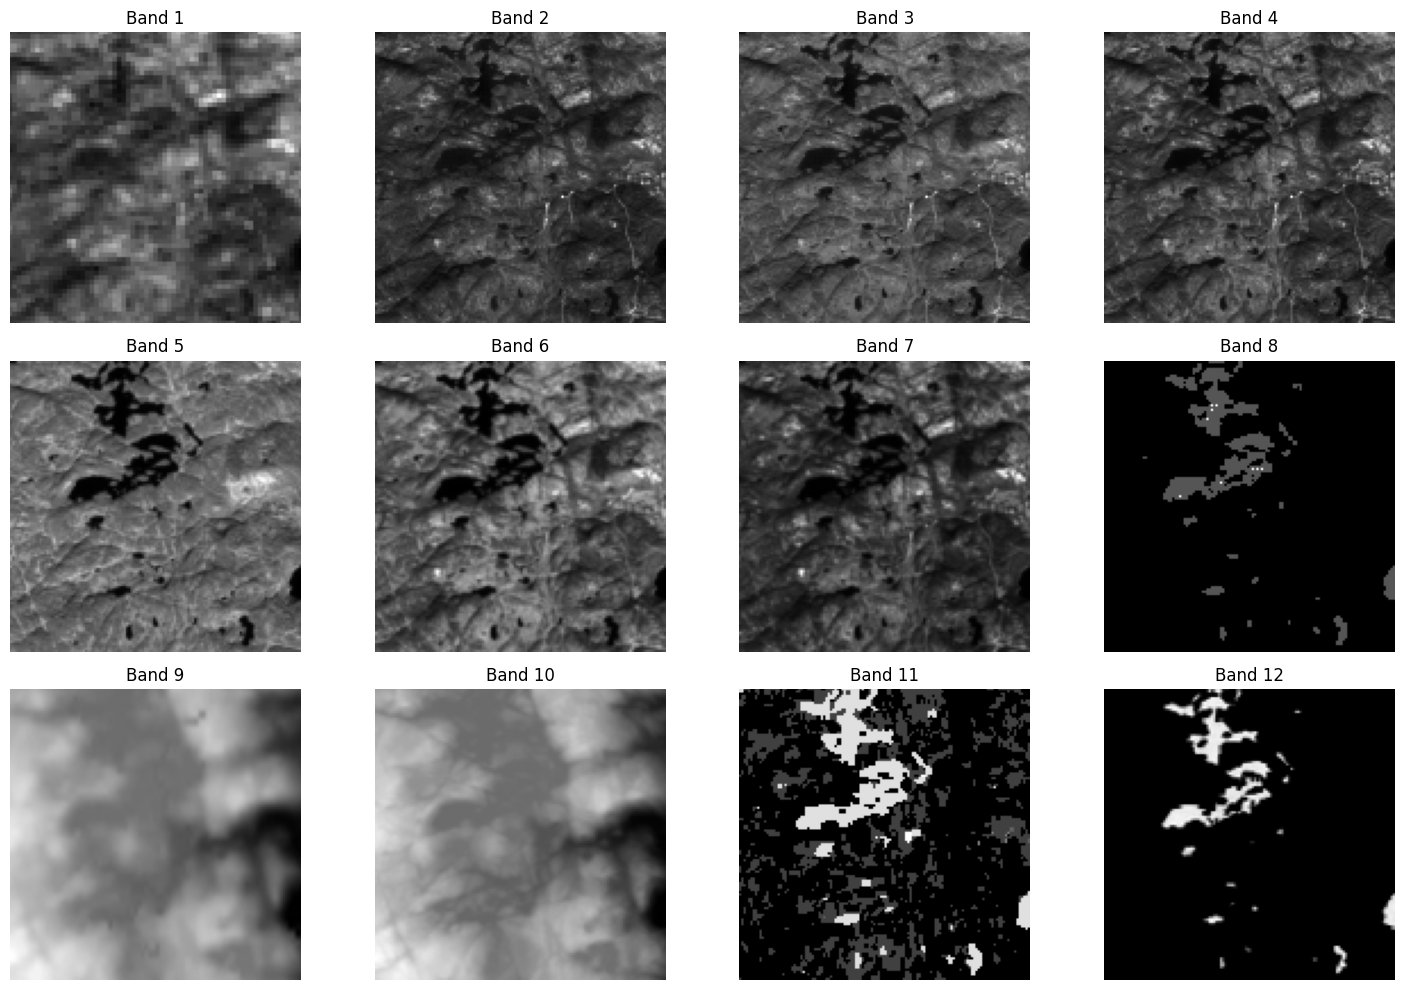

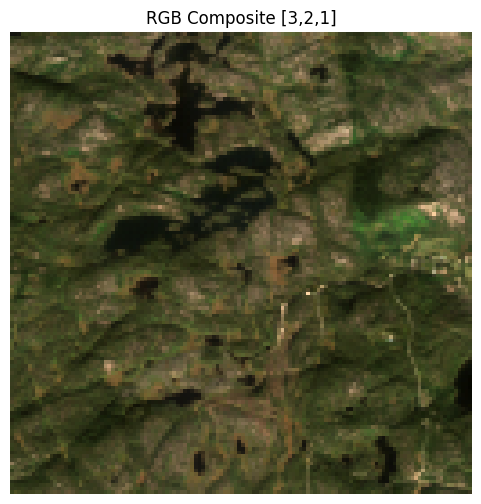

'# -----------------------\n# 3. Channel-wise MinMax Normalization\n\nnormalized = np.zeros_like(img, dtype=np.float32)\nfor i in range(img.shape[-1]):\n    band = img[:, :, i]\n    scaler = MinMaxScaler()\n    band_scaled = scaler.fit_transform(band)\n    normalized[:, :, i] = band_scaled\n\nprint("Channel-wise normalization done. Shape:", normalized.shape)'

In [63]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# single image to try
image_path = '/content/drive/MyDrive/projects/water_segmentation/satalite_data/data/images/0.tif'

img = tiff.imread(image_path)

print(f"Image shape: {img.shape}")

# -----------------------
# 1. Visualize all 12 bands

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i in range(12):
    axes[i].imshow(img[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# -----------------------
# 2. RGB Composite Visualization (bands [3, 2, 1] = Red, Green, Blue)

# Clip for visualization range
rgb = img[:, :, [3, 2, 1]].astype(np.float32)
rgb -= rgb.min()
rgb /= rgb.max() #normalizing to 0:1

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("RGB Composite [3,2,1]")
plt.axis('off')
plt.show()

"""# -----------------------
# 3. Channel-wise MinMax Normalization

normalized = np.zeros_like(img, dtype=np.float32)
for i in range(img.shape[-1]):
    band = img[:, :, i]
    scaler = MinMaxScaler()
    band_scaled = scaler.fit_transform(band)
    normalized[:, :, i] = band_scaled

print("Channel-wise normalization done. Shape:", normalized.shape)"""


In [64]:
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Function to display image and mask side by side
def display_image_and_mask(img_path, mask_path):

    img = tiff.imread(img_path)  # Shape could be (H, W, C) with many channels


    mask = Image.open(mask_path)

    # Convert to numpy if needed
    mask = np.array(mask)

    rgb_img= img[:, :, [3,2,1]].astype(np.float32)
    # Normalize to 0–1 range
    rgb_img -= rgb_img.min()
    rgb_img /= rgb_img.max()

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(rgb_img)
    axes[0].set_title('Image (RGB)')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



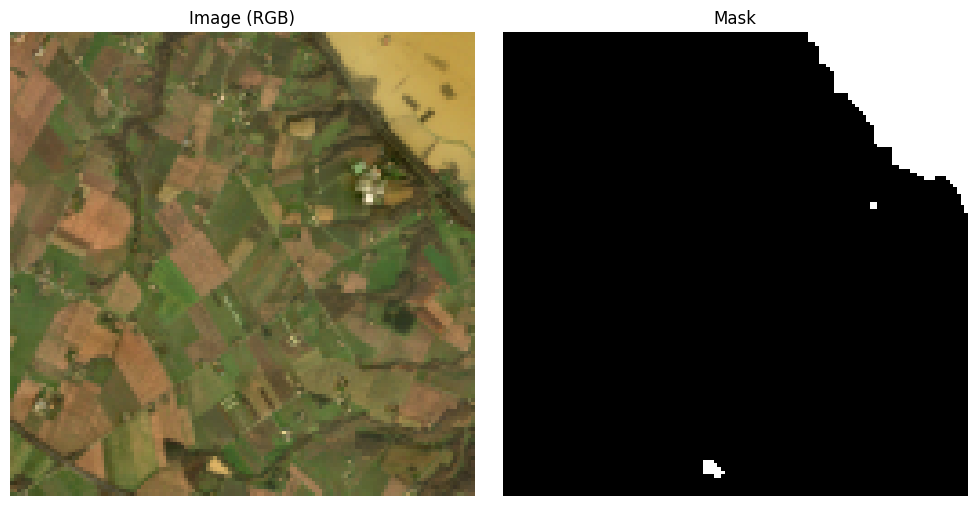

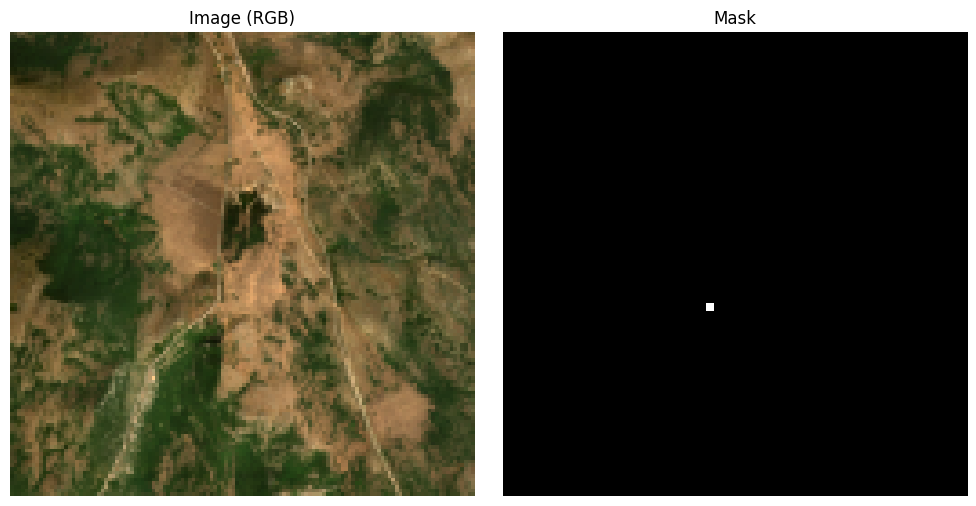

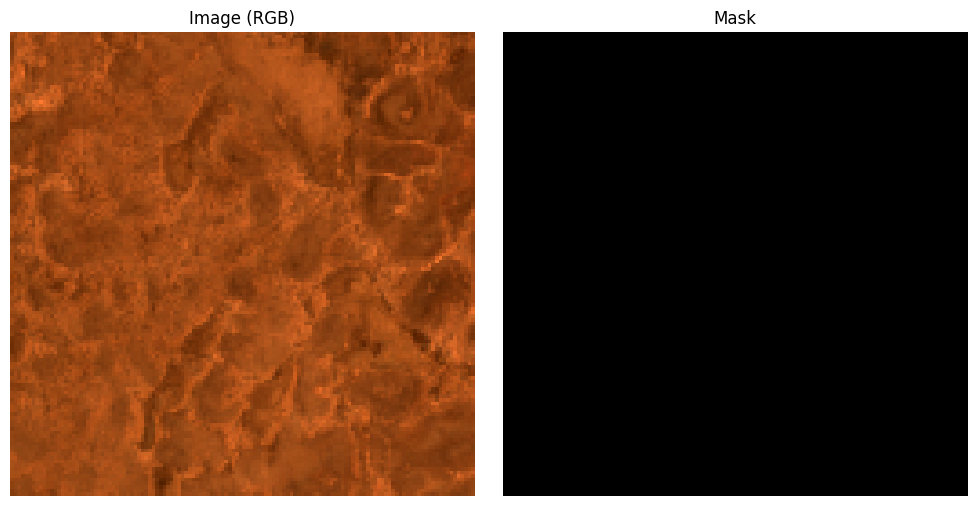

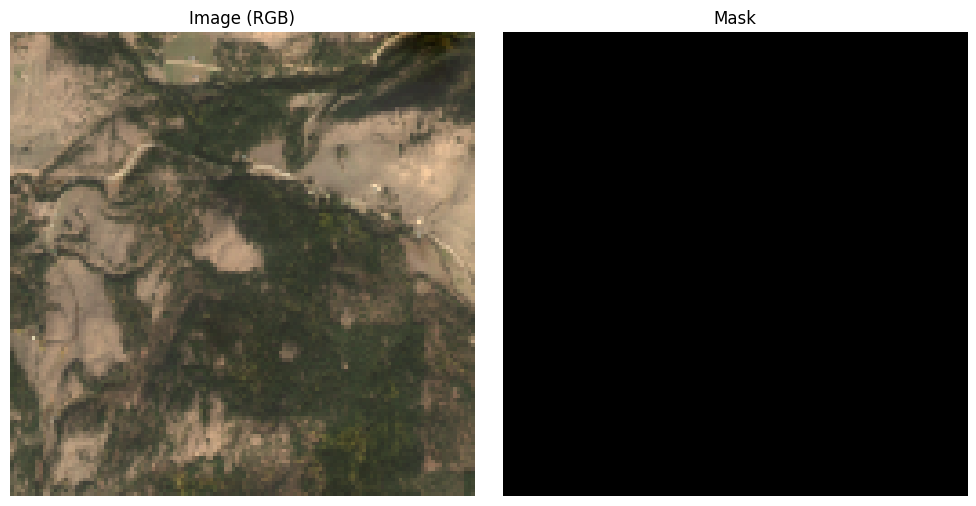

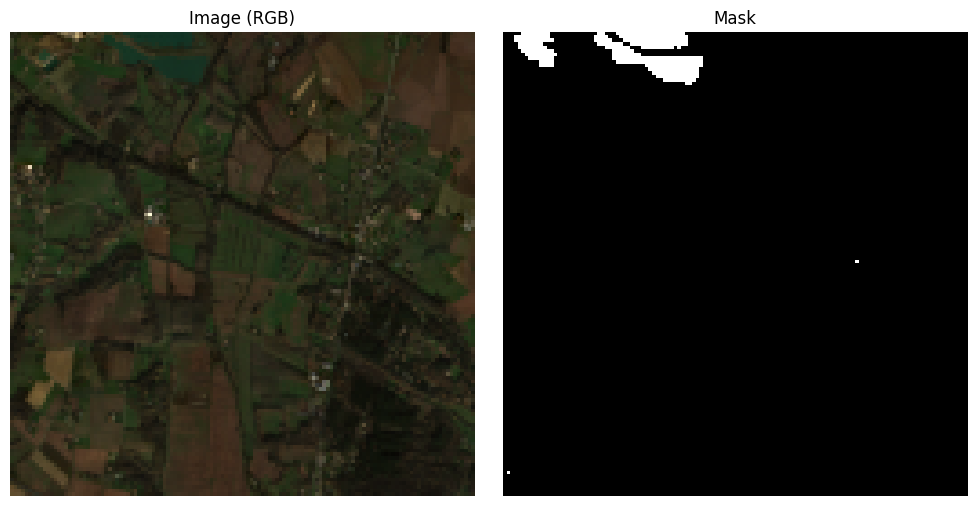

In [65]:
images_path = "/content/drive/MyDrive/projects/water_segmentation/satalite_data/data/images"
labels_path="/content/drive/MyDrive/projects/water_segmentation/satalite_data/data/labels"


images_files=sorted([ f for f in os.listdir(images_path)])
labels_files=sorted([ f for f in os.listdir(labels_path)])



image_basenames = [os.path.splitext(f)[0] for f in images_files]
mask_basenames = [os.path.splitext(f)[0] for f in labels_files]

image_basenames = {os.path.splitext(f)[0] for f in images_files}
mask_basenames = {os.path.splitext(f)[0] for f in labels_files}

# Keep only matched base names
matched_basenames = image_basenames & mask_basenames  # intersection


matched_image_paths = [os.path.join(images_path, f"{name}.tif") for name in matched_basenames]
matched_labels_paths  = [os.path.join(labels_path,  f"{name}.png") for name in matched_basenames]






if len(matched_image_paths) != len(matched_labels_paths):
  print("numbers of images and masks doesnt match")
else:
  for image,mask in zip(matched_image_paths[:5],matched_labels_paths[:5]):
    display_image_and_mask(image,mask)


#image =os.path.join(images_path, images_files[0])
#label = os.path.join(labels_path, labels_files[0])



# **Preprocessing**

normalization and band selsection

In [66]:
#normalization and loading
from tqdm import tqdm
def normalize_per_channel(image,band_indices):
  # Select all bands
    band_selected_imgs=image[:,:,band_indices]

    norm_image = np.zeros_like(band_selected_imgs, dtype=np.float32)

    for i in range(band_selected_imgs.shape[2]):
        channel = band_selected_imgs[:, :, i]
        c_min = channel.min()
        c_max = channel.max()
        if c_max - c_min != 0:
            norm_image[:, :, i] = (channel - c_min) / (c_max - c_min)
        else:
            norm_image[:, :, i] = 0  # If constant band
    return norm_image



#function claulating NDWI
def calculate_ndwi(green_band, nir_band):
    denominator = green_band + nir_band + 1e-6
    return (green_band - nir_band) / denominator




normalized_images = []
normalized_labels = []  #
band_indices=[2, 3, 4, 5, 6,7]


for mask_path in tqdm(matched_labels_paths):
    mask = np.array(Image.open(mask_path))
    normalized_labels.append(mask)


for file in tqdm(matched_image_paths):
    img = tiff.imread(file)
    img_norm = normalize_per_channel(img,band_indices)


    green_band = img_norm[:, :, 1]
    nir_band = img_norm[:, :, 3]

    # Compute NDWI
    ndwi = calculate_ndwi(green_band, nir_band)
    ndwi = ndwi[..., np.newaxis]  # reshape to (H, W, 1)
    final_input=np.concatenate([img_norm,ndwi],axis=-1)


    normalized_images.append(final_input)

100%|██████████| 306/306 [00:02<00:00, 118.30it/s]


splitting data

In [67]:
#splitting data
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming these lists contain preprocessed images/masks
X = np.array(normalized_images)
y = np.array(normalized_labels)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_train = np.squeeze(y_train)        # removes all extra singleton dims
y_train = y_train[..., np.newaxis]   # adds back just one channel dimension

y_test = np.squeeze(y_test)
y_test = y_test[..., np.newaxis]

# **Model building**

In [68]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(128, 128, 7)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [69]:
#IOU
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')       # Cast ground truth to float32
    y_pred = K.cast(y_pred > 0.5, 'float32')  # Threshold for binary mask
    intersection = K.sum(y_true * y_pred) #only true positive pixels count
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │      1,024 │ input_layer_16[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_96[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_98[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 32, 32,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_100[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 64, 64,    │      8,224 │ conv2d_101[0][0]  │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_99[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 64, 64,    │     18,464 │ concatenate_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 64, 64,    │      9,248 │ conv2d_102[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 128, 128,  │      2,064 │ conv2d_103[0][0]  │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_97[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 128, 128,  │      4,624 │ concatenate_13[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 128, 128,  │      2,320 │ conv2d_104[0][0]

 Total params: 117,617 (459.44 KB)

 Trainable params: 117,617 (459.44 KB)

 Non-trainable params: 0 (0.00 B)

X_train: (244, 128, 128, 7)
y_train: (244, 128, 128, 1)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_938']
Received: inputs=Tensor(shape=(None, 128, 128, 7))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.7869 - iou_metric: 0.0422 - loss: 0.5401 - val_accuracy: 0.8412 - val_iou_metric: 0.5383 - val_loss: 0.4681
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8954 - iou_metric: 0.5129 - loss: 0.3568 - val_accuracy: 0.8486 - val_iou_metric: 0.5824 - val_loss: 0.3960
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8871 - iou_metric: 0.5738 - loss: 0.3279 - val_accuracy: 0.8487 - val_iou_metric: 0.5653 - val_loss: 0.3898
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8942 - iou_metric: 0.5871 - loss: 0.3215 - val_accuracy: 0.8489 - val_iou_metric: 0.5623 - val_loss: 0.4020
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8910 - iou_metric: 0.5805 - loss: 0.3290 - val_accuracy: 0.8504 - val_iou_metric: 0.5662 - val_loss: 0.3958
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8942 - iou_metric: 0.5940 - loss: 0.3172 - val_accuracy: 0.8536 - val_iou_metri

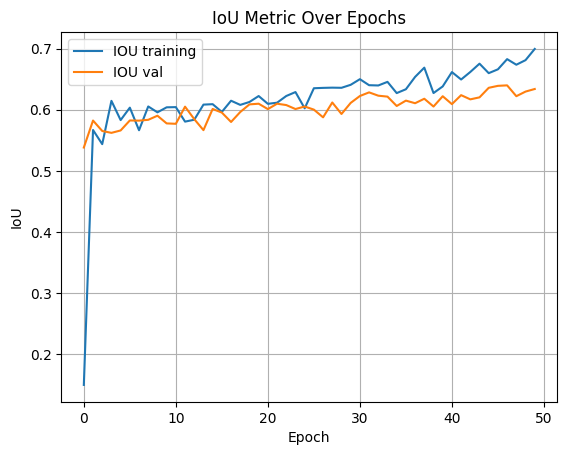

In [70]:
from tensorflow.keras.optimizers import Adam
model=unet_model(input_size=(128, 128, 7))
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])
model.summary()
"""y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)"""

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

history=model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16
)

#loss, accuracy = model.evaluate(X_test,y_test)
#print(f"Test Accuracy: {accuracy * 100:.2f}%")
plt.plot(history.history["iou_metric"],label="IOU training")
plt.plot(history.history["val_iou_metric"],label="IOU val")
plt.title('IoU Metric Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

# **Pretrained** Model

In [71]:
#customizing data to mobilnet-v2
from tensorflow.image import resize


resized_images = [resize(img, (224, 224)).numpy() for img in normalized_images]
resized_labels = [resize(mask[..., np.newaxis], (224, 224)).numpy() for mask in normalized_labels]



# Assuming these lists contain preprocessed images/masks
X = np.array(resized_images)
y = np.array(resized_labels)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [72]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D

# Input with 12 channels
input_l = Input(shape=(224, 224, 7))

# Compress 5 → 3 channels for pretrained model compatibility
compressed = Conv2D(3, (1, 1), activation='linear')(input_l)

# Load MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Use encoder from pretrained model
encoder_output = base_model.get_layer("block_13_expand_relu").output
encoder_model = Model(inputs=base_model.input, outputs=encoder_output)

# Apply encoder to compressed image
x = encoder_model(compressed)

# Decoder/Upsampling path
x = UpSampling2D((2, 2))(x)  # 28x28
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)  # 56x56
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)  # 112x112
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)  # 224x224
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Output mask (binary)
output = Conv2D(1, (1, 1), activation='sigmoid')(x)

# Final model
model = Model(inputs=input_l, outputs=output)
model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 7)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 224, 224, 3)    │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_17 (Functional)      │ (None, 14, 14, 576)    │       616,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 28, 28, 576)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 28, 28, 256)    │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 224, 224, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 224, 224, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,969 (8.89 MB)

 Trainable params: 1,714,713 (6.54 MB)

 Non-trainable params: 616,256 (2.35 MB)

Epoch 1/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5861 - iou_metric: 0.0798 - loss: 0.6444 - val_accuracy: 0.6474 - val_iou_metric: 5.9477e-05 - val_loss: 0.5784
Epoch 2/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.7163 - iou_metric: 0.0110 - loss: 0.5167 - val_accuracy: 0.7609 - val_iou_metric: 0.4032 - val_loss: 0.5002
Epoch 3/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.8332 - iou_metric: 0.4709 - loss: 0.4054 - val_accuracy: 0.7896 - val_iou_metric: 0.5303 - val_loss: 0.4776
Epoch 4/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.8308 - iou_metric: 0.5068 - loss: 0.3683 - val_accuracy: 0.7957 - val_iou_metric: 0.5061 - val_loss: 0.4529
Epoch 5/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8524 - iou_metric: 0.5402 - loss: 0.3230 - val_accuracy: 0.8052 - val_iou_metric: 0.5326 - val_loss: 0.4032
Epoch 6/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.8628 - iou_metric: 0.5850 - loss: 0.3052 - val_accuracy: 0.8148 - val_iou_

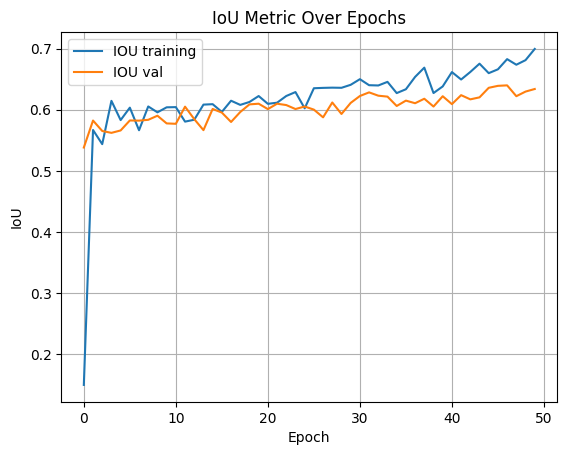

In [73]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


for layer in base_model.layers[:100]:
    base_model.trainable=False



model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
             metrics=['accuracy', iou_metric])


history2=model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=35,

)

plt.plot(history.history["iou_metric"],label="IOU training")
plt.plot(history.history["val_iou_metric"],label="IOU val")
plt.title('IoU Metric Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()